In [1]:
import pandas as pd

# Load the CSV file
csv_file_path = 'Segmentation.csv'
data = pd.read_csv(csv_file_path)

# Display the first few rows
print(data.head())


   Width  Height Mode Format  SizeBytes  FileSize FileSizeUnit  ClassId  \
0    133     115  RGB    PNG       2943      2.87           KB        1   
1     72      72  RGB    PNG       1423      1.39           KB        0   
2    147     148  RGB    PNG       2726      2.66           KB        0   
3    115      93  RGB    PNG       2339      2.28           KB        1   
4    151     155  RGB    PNG       2965      2.90           KB        1   

       ClassName                           Path  
0  Double bottom  Segmentation/1_0000_00009.png  
1     Double top  Segmentation/0_0000_00029.png  
2     Double top  Segmentation/0_0000_00059.png  
3  Double bottom  Segmentation/1_0000_00041.png  
4  Double bottom  Segmentation/1_0000_00067.png  


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Parameters
image_size = (128, 128)  # Resize images to this size

# Function to load and preprocess an image
def preprocess_image(image_path):
    image = load_img(image_path, target_size=image_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize the image to [0, 1]
    return image

# Load and preprocess all images
images = []
labels = []
for index, row in data.iterrows():
    image_path = row['Path']
    class_id = row['ClassId']
    images.append(preprocess_image(image_path))
    labels.append(class_id)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Display shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (340, 128, 128, 3)
Labels shape: (340,)


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Display shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (272, 128, 128, 3)
X_val shape: (68, 128, 128, 3)
y_train shape: (272,)
y_val shape: (68,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(data['ClassId'].unique()), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)      0

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
9/9 [==============================] - 5s 425ms/step - loss: 0.1354 - accuracy: 0.9191 - val_loss: 0.2781 - val_accuracy: 0.9559
Epoch 2/10
9/9 [==============================] - 3s 329ms/step - loss: 0.0084 - accuracy: 0.9963 - val_loss: 0.5645 - val_accuracy: 0.9853
Epoch 3/10
9/9 [==============================] - 4s 399ms/step - loss: 9.2474e-08 - accuracy: 1.0000 - val_loss: 0.7018 - val_accuracy: 0.9853
Epoch 4/10
9/9 [==============================] - 4s 407ms/step - loss: 1.1651e-04 - accuracy: 1.0000 - val_loss: 0.7195 - val_accuracy: 0.9853
Epoch 5/10
9/9 [==============================] - 4s 419ms/step - loss: 3.3308e-08 - accuracy: 1.0000 - val_loss: 0.7211 - val_accuracy: 0.9853
Epoch 6/10
9/9 [==============================] - 4s 417ms/step - loss: 8.7654e-10 - accuracy: 1.0000 - val_loss: 0.7220 - val_accuracy: 0.9853
Epoch 7/10
9/9 [==============================] - 4s 417ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.7225 - val_accuracy: 0.9853


In [10]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_acc}")

# Make predictions
predictions = model.predict(X_val)

# Display some predictions
for i in range(5):
    print(f"Actual: {y_val[i]}, Predicted: {np.argmax(predictions[i])}")


3/3 [==============================] - 0s 51ms/step - loss: 0.7228 - accuracy: 0.9853
Validation loss: 0.7227827906608582
Validation accuracy: 0.9852941036224365
3/3 [==============================] - 0s 56ms/step
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1


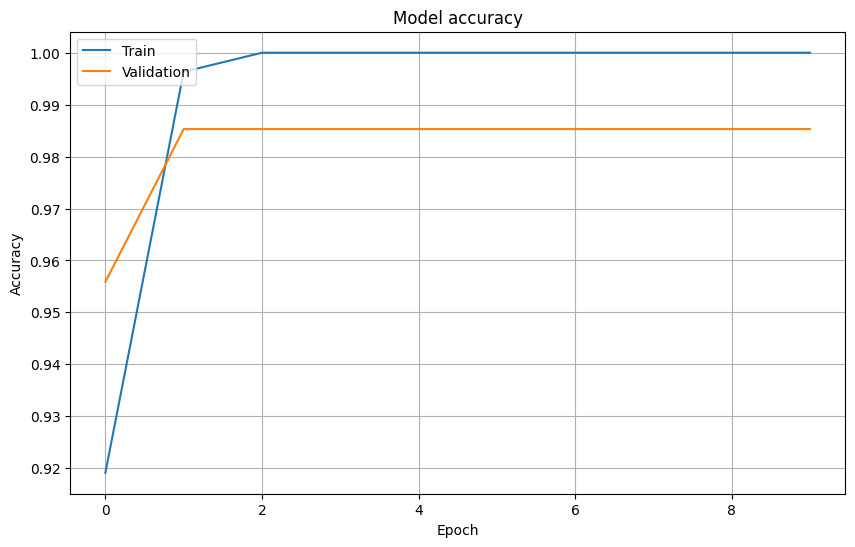

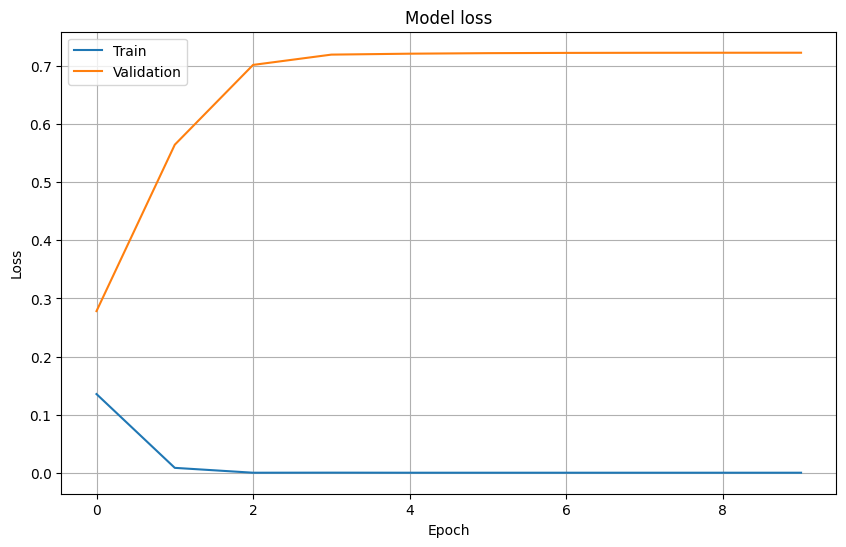

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()
